<a href="https://colab.research.google.com/github/Anderson-Shin/Anderson-Shin/blob/main/STAT3612%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%84%B8%ED%8A%B8%EC%97%90%EB%A7%9E%EC%B6%B0%EC%84%9C%EC%99%84%EB%B2%BD%ED%95%98%EA%B2%8C%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Raw Data

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')
admission_path = '/content/drive/My Drive/STAT3612_dataset/admissions.csv'
discharge_path = '/content/drive/My Drive/STAT3612_dataset/discharge.csv'
df_adm = pd.read_csv(admission_path)
df_discharge = pd.read_csv(discharge_path)

Mounted at /content/drive


Dataframe implemented here are raw data from MIMIC IV data set. Where df_adm(contains admission data such as admittime, discharge time and so on)is admission data and df_discharge is discharge data(contain discharge notes, note type, chart time and so on)

In [ ]:
# ADMISSIONS Data
df_adm1 = df_adm.copy()
df_adm1.admittime = pd.to_datetime(df_adm1.admittime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_adm1.dischtime = pd.to_datetime(df_adm1.dischtime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_adm1.deathtime = pd.to_datetime(df_adm1.deathtime, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# arrange according to subject_id and admittime
df_adm1 = df_adm1.sort_values(['subject_id', 'admittime']).reset_index(drop=True)

# next_admittime & next_admission_type creation
df_adm1['next_admittime'] = df_adm1.groupby('subject_id').admittime.shift(-1)
df_adm1['next_admission_type'] = df_adm1.groupby('subject_id').admission_type.shift(-1)

# # eliminate ELECTIVE type
# df_adm1 = df_adm1[df_adm1['admission_type'] != 'ELECTIVE']

# rearrange and calculate days between next admission
df_adm1 = df_adm1.sort_values(['subject_id', 'admittime'])
df_adm1[['next_admittime', 'next_admission_type']] = df_adm1.groupby(['subject_id'])[['next_admittime', 'next_admission_type']].fillna(method='bfill')
df_adm1['days_next_admit'] = (df_adm1.next_admittime - df_adm1.dischtime).dt.total_seconds() / (24 * 60 * 60)

# creat output_label intto readmitted_within_30days
df_adm1['output_label'] = (df_adm1.days_next_admit < 30).astype('int')
df_adm1['id'] = df_adm['subject_id'].astype(str) + '_' + df_adm['hadm_id'].astype(str)
df_adm1 = df_adm1[['id'] + [col for col in df_adm1.columns if col != 'id']]
df_adm1 = df_adm1.rename(columns={'output_label': 'readmitted_within_30days'})


<ipython-input-2-a3278ed3b1a7>:19: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  df_adm1[['next_admittime', 'next_admission_type']] = df_adm1.groupby(['subject_id'])[['next_admittime', 'next_admission_type']].fillna(method='bfill')
<ipython-input-2-a3278ed3b1a7>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adm1[['next_admittime', 'next_admission_type']] = df_adm1.groupby(['subject_id'])[['next_admittime', 'next_admission_type']].fillna(method='bfill')
<ipython-input-2-a3278ed3b1a7>:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set

Above code trims the admission dataframe into extended dataframe with calculation of days between readmission and create the classification column in 0 and 1 according to readmitted_within_30days.I have added extra column 'id' as 'subject_id'+'_'+'hadm_id' for further use for data set given in the 3612 course and also changed the 'output_label' to 'readmitted_within_30days' to match dataframe flow for 3612 course data.

In [ ]:
# Discharge data -> Notes Data
df_discharge1 = df_discharge.copy()
df_discharge1['charttime'] = pd.to_datetime(df_discharge1['charttime']).dt.date
df_adm1['admittime'] = pd.to_datetime(df_adm1['admittime']).dt.date
df_adm1['dischtime'] = pd.to_datetime(df_adm1['dischtime']).dt.date
df_discharge1['id'] = df_discharge1['subject_id'].astype(str) + '_' + df_discharge1['hadm_id'].astype(str)
df_discharge1 = df_discharge1[['id'] + [col for col in df_discharge1.columns if col != 'id']]



After loading the discharge data, I have changed the time format of admittime and dischtime into date since charttime in discharge data only contain the date but not timestamps. Then I have added 'id' column that I forementioned above to align with STAT3612 data set frame.

In [ ]:
def clean_and_merge_adm_discharge(df_adm1, df_discharge1):
    """
    Merges admission and discharge dataframes, resolves '_x' and '_y' suffixes, and keeps meaningful columns.

    Parameters:
        df_adm1 (pd.DataFrame): DataFrame containing admission data.
        df_discharge1 (pd.DataFrame): DataFrame containing discharge data.

    Returns:
        pd.DataFrame: Cleaned and merged DataFrame.
    """
    # Perform the merge
    merged_df = pd.merge(df_adm1, df_discharge1, on='id', how='inner')

    # Rename or drop columns with suffixes _x and _y
    column_mapping = {
        'subject_id_x': 'subject_id',
        'hadm_id_x': 'hadm_id',
        'admittime': 'admittime',
        'dischtime': 'dischtime',
        'deathtime': 'deathtime',
        'subject_id_y': 'discharge_subject_id',
        'hadm_id_y': 'discharge_hadm_id'
    }

    # Rename the columns based on mapping
    merged_df.rename(columns=column_mapping, inplace=True)

    # Drop redundant columns if they don't add value
    merged_df.drop(['discharge_subject_id', 'discharge_hadm_id'], axis=1, inplace=True)

    return merged_df


df_adm_notes = clean_and_merge_adm_discharge(df_adm1, df_discharge1)



Merge discharge and admission dataframe into a single dataframe according to 'id' column

In [ ]:
def check_column_values(df, column_name):
    """
    Prints unique values and value counts of a specified column in the dataframe.

    Parameters:
        df (pd.DataFrame): The dataframe to inspect.
        column_name (str): The column whose values need to be checked.
    """
    print(f"Unique values in column '{column_name}':")
    print(df[column_name].unique())  # Display unique values

    print("\nValue counts in column '{column_name}':")
    print(df[column_name].value_counts())  # Display counts of each unique value
check_column_values(df_discharge1, 'note_type')


Unique values in column 'note_type':
['DS']

Value counts in column '{column_name}':
note_type
DS    331793
Name: count, dtype: int64


Further clean the dataframe according to the note_type so that it only contains discharge text data in the dataframe.

In [ ]:
import pandas as pd

def merge_adm_discharge(df_adm1, df_discharge1):
    """
    Merges the admission and discharge dataframes on the 'id' column and filters relevant columns.

    Parameters:
        df_adm1 (pd.DataFrame): DataFrame containing admission data.
        df_discharge1 (pd.DataFrame): DataFrame containing discharge data.

    Returns:
        pd.DataFrame: Merged DataFrame with columns 'id', 'subject_id', 'hadm_id', 'text', and 'readmitted_within_30days'.
    """
    # Filter df_discharge1 for rows where note_type is 'DS'
    df_discharge_filtered = df_discharge1[df_discharge1['note_type'] == 'DS']

    # Select only the necessary columns from df_discharge1
    df_discharge_filtered = df_discharge_filtered[['id', 'text']]

    # Select only the necessary columns from df_adm1
    df_adm_filtered = df_adm1[['id', 'subject_id', 'hadm_id', 'readmitted_within_30days']]

    # Merge the two dataframes on the 'id' column
    merged_df = pd.merge(df_adm_filtered, df_discharge_filtered, on='id', how='inner')

    return merged_df

discharge_only = merge_adm_discharge(df_adm1, df_discharge1)


Trim the discharge_only dataframe according to the format which contains id,subject_id, hadm_id, text and readmitted_within_30days columns.

In [ ]:
# charttime 및 admittime_C 처리
df_adm_notes['admittime_C'] = df_adm_notes.admittime.apply(lambda x: str(x).split(' ')[0])
df_adm_notes['admittime_C'] = pd.to_datetime(df_adm_notes.admittime_C, format='%Y-%m-%d', errors='coerce')
df_adm_notes['charttime'] = pd.to_datetime(df_adm_notes.charttime, format='%Y-%m-%d', errors='coerce')

Change the timestamp data in to date format for calcuation of days in between admission time and chart time to get early notes dataframe.

In [ ]:
from datetime import timedelta

def prepare_clinical_data(df_adm1, df_discharge1, n_days):
    # Ensure datetime conversion for 'admittime' and 'charttime'
    df_adm1['admittime'] = pd.to_datetime(df_adm1['admittime'])
    df_discharge1['charttime'] = pd.to_datetime(df_discharge1['charttime'])

    # Merging the two dataframes on subject_id and hadm_id
    df_merged = pd.merge(
        df_adm1[['subject_id', 'hadm_id', 'admittime', 'readmitted_within_30days']],
        df_discharge1[['subject_id', 'hadm_id', 'charttime', 'text']],
        on=['subject_id', 'hadm_id'],
        how='inner'
    )

    # Calculate the difference between charttime and admission time to check if it is within n_days
    df_merged['days_from_admission'] = (df_merged['charttime'] - df_merged['admittime']).dt.days

    # Filter based on n_days
    df_merged = df_merged[df_merged['days_from_admission'] < n_days]

    # Remove the 'days_from_admission' column as it's not needed for the final output
    df_merged = df_merged.drop(columns=['days_from_admission'])

    # Create the final dataframe with separate subject_id, hadm_id, text, and readmitted_within_30days
    df_final = df_merged[['subject_id', 'hadm_id', 'text', 'readmitted_within_30days']]

    # Optional: If you want to use 'id' as a combination of subject_id and hadm_id, you can create it
    df_final['id'] = df_final['subject_id'].astype(str) + '_' + df_final['hadm_id'].astype(str)

    return df_final


df_less_2 = prepare_clinical_data(df_adm1, df_discharge1, 2)
df_less_3 = prepare_clinical_data(df_adm1, df_discharge1, 3)
print(df_less_2.shape)
print(df_less_3.shape)


<ipython-input-11-8f4d2ce7c5e7>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['id'] = df_final['subject_id'].astype(str) + '_' + df_final['hadm_id'].astype(str)


(65143, 5)
(119416, 5)


<ipython-input-11-8f4d2ce7c5e7>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['id'] = df_final['subject_id'].astype(str) + '_' + df_final['hadm_id'].astype(str)


df_less_2 indicating that this dataframe contains early note dataframe with same columns as discharge_only dataframe above but the text data is based on 2 days after the admission.

In [ ]:
import pandas as pd

def label_percentage(df):
    # Calculate the count of 0s and 1s in the 'Label' column
    label_counts = df['readmitted_within_30days'].value_counts(normalize=True) * 100

    # Return the percentages
    return label_counts
label_percentage(discharge_only)

,proportion
readmitted_within_30days,
0,82.21142
1,17.78858


Check the class imbalance between 0 and 1 for dataframe trimmed. As a result, we can observe that the ratio of 0 to 1 is approximately 18:82, showing bias for class distribution (too many 1 values compare to 0)

In [ ]:
discharge_only.to_csv('/content/drive/My Drive/STAT3612_dataset/raw_data/df_raw_discharge_only.csv', index=False)
df_adm1.to_csv('/content/drive/My Drive/STAT3612_dataset/raw_data/df_raw_adm1.csv', index=False)
df_adm_notes.to_csv('/content/drive/My Drive/STAT3612_dataset/raw_data/df_raw_adm_notes.csv', index=False)
df_less_2.to_csv('/content/drive/My Drive/STAT3612_dataset/raw_data/df_raw_less_2.csv', index=False)
df_less_3.to_csv('/content/drive/My Drive/STAT3612_dataset/raw_data/df_raw_less_3.csv', index=False)


I will handle the imbalance issues in the coming blocks of code below.

#STAT3612 data

This Section mainly focus on the test,val,train dataset given by the course.

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')
admission_path = '/content/drive/My Drive/STAT3612_dataset/admissions.csv'
discharge_path = '/content/drive/My Drive/STAT3612_dataset/discharge.csv'
train = pd.read_csv('/content/drive/My Drive/STAT3612_dataset/train.csv')
test = pd.read_csv('/content/drive/My Drive/STAT3612_dataset/test.csv')
val = pd.read_csv('/content/drive/My Drive/STAT3612_dataset/valid.csv')
notes = pd.read_csv('/content/drive/My Drive/STAT3612_dataset/notes.csv')

Mounted at /content/drive


In [ ]:
print(train.shape)
print(val.shape)
print(test.shape)

(49451, 8)
(16721, 8)
(16293, 7)


In [ ]:
# Check for duplicates in the 'id' column
duplicates = test['id'].duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()
print(f"There are {num_duplicates} duplicated entries in the 'id' column.")

# Optionally, display all duplicate rows
if num_duplicates > 0:
    duplicate_rows = df_adm1[df_adm1['id'].duplicated(keep=False)]
    print("Duplicate rows:")
    print(duplicate_rows)
else:
    print("No duplicates found in the 'id' column.")

There are 13552 duplicated entries in the 'id' column.
Duplicate rows:
Empty DataFrame
Columns: [id, subject_id, hadm_id, admittime, dischtime, deathtime, admission_type, admission_location, discharge_location, insurance, language, marital_status, ethnicity, edregtime, edouttime, hospital_expire_flag, next_admittime, next_admission_type, days_next_admit, readmitted_within_30days]
Index: []


As we can observe, there are many duplicates in id column and we need to further check the consistency of 'readmitted_within_30days' columns for duplicated id values

check whether there is consistency with duplicates in id colum for test,val,train with readmitted values

In [ ]:
import pandas as pd

def check_readmission_consistency(df):
    """
    This function checks if all rows with duplicated 'id' values have the same value
    for 'readmitted_within_30days'.

    Parameters:
    df (pd.DataFrame): The input pandas DataFrame.

    Returns:
    bool: True if all duplicated 'id' values have consistent 'readmitted_within_30days',
          False otherwise.
    """
    # Find duplicated 'id' values
    duplicated_ids = df[df.duplicated(subset='id', keep=False)]

    # Group by 'id' and check if all 'readmitted_within_30days' values are the same within each group
    consistent = duplicated_ids.groupby('id')['readmitted_within_30days'].nunique().eq(1).all()

    return consistent

# Check for consistency
result = check_readmission_consistency(train)

# Print the result
if result:
    print("All duplicated 'id' values have the same 'readmitted_within_30days' value.")
else:
    print("Some duplicated 'id' values have different 'readmitted_within_30days' values.")


All duplicated 'id' values have the same 'readmitted_within_30days' value.


It seems there is no inconsistency between duplicated id values and we can then remove does duplicates

In [ ]:
import pandas as pd

def eliminate_duplicates(df, column_name):
    """
    This function takes a pandas DataFrame and a column name as input,
    and returns a new DataFrame with duplicates removed from the specified column.

    Parameters:
    df (pd.DataFrame): The input pandas DataFrame.
    column_name (str): The name of the column from which duplicates will be removed.

    Returns:
    pd.DataFrame: A new DataFrame with duplicates removed in the specified column.
    """
    # Drop duplicates based on the specified column
    df_unique = df.drop_duplicates(subset=[column_name]).reset_index(drop=True)
    return df_unique

# Example usage:
# Assuming 'train' is your input DataFrame and 'id' is the column of interest
train_unique = eliminate_duplicates(train, 'id')
val_unique = eliminate_duplicates(val, 'id')
test_unique = eliminate_duplicates(test, 'id')
print(train_unique.shape)
print(val_unique.shape)
print(test_unique.shape)

(8234, 8)
(2788, 8)
(2741, 7)


Succesfully removed all duplicates and now the dataframes have its only id values

In [ ]:
import pandas as pd

def check_id_existence(train_unique, notes):
    """
    This function checks if 'id' values in the train_unique dataframe
    exist in the 'id' column of the notes dataframe. It then counts how many
    exist and how many do not exist.

    Parameters:
    train_unique (pd.DataFrame): The dataframe containing 'id' values to check.
    notes (pd.DataFrame): The dataframe in which the 'id' values are being checked.

    Returns:
    dict: A dictionary containing counts of existing and non-existing 'id' values.
    """
    # Check if 'id' in train_unique exists in 'id' column of notes
    existing_ids = train_unique['id'].isin(notes['id'])

    # Count the number of existing and non-existing 'id' values
    num_existing = existing_ids.sum()  # True counts as 1
    num_non_existing = len(existing_ids) - num_existing  # Total - existing

    return {
        'existing_count': num_existing,
        'non_existing_count': num_non_existing
    }

# Example usage:
# Assuming train_unique and notes are your dataframes


# Call the function to check existence
result = check_id_existence(test_unique,notes)

# Print the result
print(f"Number of 'id' values that exist: {result['existing_count']}")
print(f"Number of 'id' values that do not exist: {result['non_existing_count']}")



Number of 'id' values that exist: 2741
Number of 'id' values that do not exist: 0


Now, we need to check whether id values in the train,val,test data exist in the discharge_only dataframe (because this contains the actual ground truth for readmission label for test data)

In [ ]:
import pandas as pd

def merge_dataframes(notes, train_unique):
    """
    Merges the 'notes' and 'train_unique' dataframes on 'id', 'subject_id', and 'hadm_id'.

    Parameters:
        notes (pd.DataFrame): DataFrame containing clinical notes.
        train_unique (pd.DataFrame): DataFrame containing readmission information.

    Returns:
        pd.DataFrame: Merged DataFrame with columns ['id', 'subject_id', 'hadm_id', 'text', 'readmitted_within_30days'].
    """
    # Perform an inner merge on the specified columns
    merged_df = pd.merge(
        notes[['id', 'subject_id', 'hadm_id', 'text']],
        train_unique[['id', 'subject_id', 'hadm_id', 'readmitted_within_30days']],
        on=['id', 'subject_id', 'hadm_id'],
        how='inner'
    )

    # Check if 'readmitted_within_30days' is of boolean type and convert explicitly
    if merged_df['readmitted_within_30days'].dtype == bool:
        merged_df['readmitted_within_30days'] = merged_df['readmitted_within_30days'].astype(int)

    # If it is not boolean, explicitly apply conversion to 0 and 1
    else:
        merged_df['readmitted_within_30days'] = merged_df['readmitted_within_30days'].apply(lambda x: 1 if x else 0)

    # Select only the required columns in the specified order
    merged_df = merged_df[['id', 'subject_id', 'hadm_id', 'text', 'readmitted_within_30days']]

    return merged_df

# Example usage
train_notes = merge_dataframes(notes, train_unique)
val_notes = merge_dataframes(notes, val_unique)

print(train_notes.shape)
print(val_notes.shape)


(8234, 5)
(2788, 5)


Merge train, val dataframes with the notes datafile which was also given in the course.

In [ ]:
import pandas as pd

def merge_dataframes_with_test(test_unique, df_adm_notes):
    """
    Merges the 'test_unique' and 'df_adm_notes' dataframes on 'id'.
    Adds 'readmitted_within_30days' and 'text' columns from df_adm_notes.

    Parameters:
        test_unique (pd.DataFrame): DataFrame containing 'id', 'subject_id', and 'hadm_id'.
        df_adm_notes (pd.DataFrame): DataFrame containing clinical notes with 'id', 'readmitted_within_30days', and 'text'.

    Returns:
        pd.DataFrame: Merged DataFrame with selected columns.
    """
    # Strip any extra whitespace from column names to avoid key errors
    df_adm_notes.columns = df_adm_notes.columns.str.strip()
    test_unique.columns = test_unique.columns.str.strip()

    # Merge the dataframes on 'id' column
    merged_df = pd.merge(
        test_unique[['id', 'subject_id', 'hadm_id']],  # Columns from test_unique
        df_adm_notes[['id', 'readmitted_within_30days', 'text']],  # Columns from df_adm_notes
        on='id',
        how='inner'  # Use 'inner' to keep only matching rows
    )

    return merged_df

# Example usage
test_notes = merge_dataframes_with_test(test_unique, df_adm_notes)

# Print the resulting merged dataframe
test_notes.shape


(2741, 5)

For test dataframe, I merged with the df_adm_notes dataframe which we constructed in the raw data section. It is because test dataframe does not contain 'readmitted_within_30days' column and therefore, I used df_adm_notes which contains the ground truth for readmitted_within_30days and also text data.

check the class proportion

In [ ]:
train_notes.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/train_notes.csv', index=False)
val_notes.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/val_notes.csv', index=False)
test_notes.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/test_notes.csv', index=False)


In [ ]:
import pandas as pd

def label_percentage(df):
    # Calculate the count of 0s and 1s in the 'Label' column
    label_counts = df['readmitted_within_30days'].value_counts(normalize=True) * 100

    # Return the percentages
    return label_counts
label_percentage(test_notes)

,proportion
readmitted_within_30days,
0,81.940897
1,18.059103


Again when we check the proportion of readmitted_within_30days class proprotion it is about 82:18, indicating class bias. I will discuss about it later after text cleaning

# Text cleaning

In [ ]:
import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm


KeyboardInterrupt: 

In [ ]:
# Download stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove text within square brackets (e.g., [diagnosis] or [note])
    text = re.sub(r'\[.*?\]', '', text)

    # Remove unwanted special characters and punctuation
    text = re.sub(r'[/":+]', '', text)
    text = re.sub(r'_', '', text)

    # Remove all digits
    text = re.sub(r'\d+', '', text)

    # Normalize abbreviations and common clinical terms
    text = re.sub(r'dr\.', 'doctor', text)  # Normalize 'dr.' to 'doctor'
    text = re.sub(r'm\.d\.', 'md', text)    # Normalize 'm.d.' to 'md'

    # Remove specific phrases that are not relevant (e.g., admission/discharge dates)
    text = re.sub(r'admission date:', '', text)
    text = re.sub(r'discharge date:', '', text)

    # Remove double hyphens, underscores, or equal signs used as separators
    text = re.sub(r'--|__|==', '', text)

    # Remove unwanted special characters like '<', '>', and periods used as incorrect markers
    text = re.sub(r'[<>]', '', text)
    text = re.sub(r'\.[a-zA-Z]', '', text)  # Remove misplaced periods followed by a letter

    # Remove hashtags like '# hepatic encephalopathy' or '# nutrition'
    text = re.sub(r'#\s*\w+', '', text)

    # Clean up periods that are misplaced or unnecessary (e.g., protein .)
    text = re.sub(r'\s*\.\s*', ' ', text)

    # Replace asterisks with spaces to preserve word separation
    text = re.sub(r'\*+', ' ', text)

    # Remove extra spaces or leading/trailing whitespace
    text = text.strip()

    # Remove stop words
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])

    return text

def preprocess_text_data(df):
    print(f"Original dataframe shape: {df.shape}")

    # Preprocess text data: handle NaN values, newlines, and extra spaces
    df['text'] = df['text'].fillna(' ').str.replace('\n', ' ').replace('\r', ' ').str.strip().str.lower()

    # Apply text cleaning
    df['text'] = df['text'].apply(clean_text)

    # Group by `hadm_id` to aggregate all text entries for each unique `hadm_id`
    # Concatenate text entries into a single string for each `hadm_id`
    df = df.groupby('id').agg({
        'text': ' '.join,           # Concatenate all text for each `hadm_id`
        'readmitted_within_30days': 'first'     # Use the first label for each `readmitted_within_30days` if consistent
    }).reset_index()

    # Rename columns to match expected output
    df.rename(columns={'readmitted_within_30days': 'Label', 'id': 'ID'}, inplace=True)

    print(f"Processed dataframe shape: {df.shape}")
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
test_notes_cleaned = preprocess_text_data(test_notes)
val_notes_cleaned = preprocess_text_data(val_notes)
train_notes_cleaned = preprocess_text_data(train_notes)

Original dataframe shape: (2741, 5)
Processed dataframe shape: (2741, 3)
Original dataframe shape: (2788, 5)
Processed dataframe shape: (2788, 3)
Original dataframe shape: (8234, 5)
Processed dataframe shape: (8234, 3)


After the data preprocess_text_data function, each train,test,val dataset will have three columns which are 'ID', 'Label' and 'text'

In [ ]:
# train_notes_cleaned.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/train_notes_cleaned.csv', index=False)
# val_notes_cleaned.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/val_notes_cleaned.csv', index=False)
# test_notes_cleaned.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/test_notes_cleaned.csv', index=False)

In [ ]:
# # df_discharge_only = preprocess_text_data(df_discharge_only)
# df_less_2_cleaned = preprocess_text_data(df_less_2)
# df_less_3_cleaned = preprocess_text_data(df_less_3)
# discharge_only_cleaned = preprocess_text_data(discharge_only)

In [ ]:
# df_discharge_only.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/df_discharge_only.csv', index=False)
# df_adm1.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/df_adm1.csv', index=False)
# df_adm_notes.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/df_adm_notes1.csv', index=False)
# df_less_2_only.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/df_less_2_only.csv', index=False)
# df_less_3_only.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/df_less_3_only.csv', index=False)


#Balancing procedure

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')

train_notes_cleaned = pd.read_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/train_notes_cleaned.csv')
val_notes_cleaned = pd.read_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/val_notes_cleaned.csv')
test_notes_cleaned = pd.read_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/test_notes_cleaned.csv')


Mounted at /content/drive


In [ ]:
print(train_notes_cleaned.shape)
print(val_notes_cleaned.shape)
print(test_notes_cleaned.shape)

(8234, 3)
(2788, 3)
(2741, 3)


In [ ]:
print(train_notes_cleaned['Label'].value_counts())

Label
0    6785
1    1449
Name: count, dtype: int64


In [ ]:
!pip install imbalanced-learn

I have implemented downsampling and upsampling but chose downsampling since it reduce the size of the datasets.

In [ ]:
def handle_imbalance(df, text_column, label_column, method='downsampling'):

    # Separate classes
    class_1 = df[df[label_column] == 1]  # Class with label 1
    class_0 = df[df[label_column] == 0]  # Class with label 0

    # Identify majority and minority
    if len(class_1) > len(class_0):
        majority, minority = class_1, class_0
    else:
        majority, minority = class_0, class_1

    if method == 'downsampling':
        # Downsample majority to minority size
        majority_downsampled = resample(
            majority,
            replace=False,  # No replacement for downsampling
            n_samples=len(minority),  # Match minority size
            random_state=42
        )
        balanced_df = pd.concat([majority_downsampled, minority])

    elif method == 'upsampling':
        # Upsample minority to majority size
        minority_upsampled = resample(
            minority,
            replace=True,  # Allow replacement for upsampling
            n_samples=len(majority),  # Match majority size
            random_state=42
        )
        balanced_df = pd.concat([majority, minority_upsampled])

    else:
        raise ValueError("Invalid method. Choose 'downsampling' or 'upsampling'.")

    return balanced_df


In [ ]:
train_upsampled = handle_imbalance(train_notes_cleaned, text_column='text', label_column='Label', method='upsampling')
val_upsampled = handle_imbalance(val_notes_cleaned, text_column='text', label_column='Label', method='upsampling')
test_upsampled = handle_imbalance(test_notes_cleaned, text_column='text', label_column='Label', method='upsampling')
print(f"Downsampled Class Distribution:\n{val_upsampled['Label'].value_counts()}")
print(val_upsampled.shape)

Downsampled Class Distribution:
Label
0    2307
1    2307
Name: count, dtype: int64
(4614, 3)


In [ ]:
# train_upsampled.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/upsampling_test/train_upsampled.csv', index=False)
# val_upsampled.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/upsampling_test/val_upsampled.csv', index=False)
# test_upsampled.to_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/upsampling_test/test_upsampled.csv', index=False)


As a result, we have 1 to 1 class proportion between classes (0 and 1)

In [ ]:
import pandas as pd

def label_percentage(df):
    # Calculate the count of 0s and 1s in the 'Label' column
    label_counts = df['Label'].value_counts(normalize=True) * 100

    # Return the percentages
    return label_counts
label_percentage(test_downsampled)

,proportion
Label,
0,50.0
1,50.0


#Modeling (Imbalanced Label)

In [2]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
train_notes_cleaned = pd.read_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/train_notes_cleaned.csv')
val_notes_cleaned = pd.read_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/val_notes_cleaned.csv')
test_notes_cleaned = pd.read_csv('/content/drive/My Drive/STAT3612_dataset/STAT3612_data_preprocessing_final/test_notes_cleaned.csv')

Mounted at /content/drive


In [1]:
import torch
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, WeightedRandomSampler
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, roc_curve, precision_recall_curve, auc)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler  # Oversampling 추가
import matplotlib.pyplot as plt
import numpy as np



# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ClinicalBERT 불러오기
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
# model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=2).to(device)
model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=2, hidden_dropout_prob=0.2).to(device)  # Dropout 비율 증가)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# Focal Loss 정의 (alpha 값 변경)
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.815, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = torch.nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")


In [3]:
# 데이터 준비 및 토큰화 함수
def prepare_data_and_tokenize(df):
    texts = df['text'].tolist()
    labels = df['Label'].tolist()

    input_ids = []
    attention_masks = []

    print("Tokenizing data...")
    for text in tqdm(texts, desc="Tokenizing texts", unit="text"):
        encoded_dict = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [ ]:
# # Oversampling 함수 추가
# def oversample_data(input_ids, attention_masks, labels):
#     print("Performing oversampling...")
#     ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
#     # 데이터 Reshape 필요
#     input_ids_np = input_ids.numpy()
#     attention_masks_np = attention_masks.numpy()
#     labels_np = labels.numpy()
#     # Oversampling 실행
#     input_ids_resampled, labels_resampled = ros.fit_resample(input_ids_np, labels_np)
#     attention_masks_resampled, _ = ros.fit_resample(attention_masks_np, labels_np)
#     return torch.tensor(input_ids_resampled), torch.tensor(attention_masks_resampled), torch.tensor(labels_resampled)


In [4]:
# DataLoader 생성 함수 (Weighted Sampler 추가)
def create_data_loader(input_ids, attention_masks, labels, batch_size=32, sampler_type="weighted"):
    dataset = TensorDataset(input_ids, attention_masks, labels)
    if sampler_type == "weighted":
        # Class Weight 기반 Sampler 생성
        class_counts = np.bincount(labels.numpy())
        class_weights = 1.0 / class_counts
        weights = class_weights[labels.numpy()]
        sampler = WeightedRandomSampler(weights, len(weights))
    else:
        sampler = RandomSampler(dataset)
    return DataLoader(dataset, sampler=sampler, batch_size=batch_size)


In [5]:
# Training function with Focal Loss
def train_with_focal_loss(model, dataloader, optimizer, scheduler, loss_fn, alpha=1, gamma=2):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        scheduler.step()

    return total_loss / len(dataloader)


In [6]:
# 평가 함수 (Precision-Recall Curve 추가)
def evaluate(model, dataloader):
    model.eval()
    total_eval_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            total_eval_loss += outputs.loss.item()

            logits = outputs.logits
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())
            probs = torch.nn.functional.softmax(logits, dim=1)
            all_probs.extend(probs.cpu().numpy()[:, 1])

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    auroc = roc_auc_score(all_labels, all_probs)

    # Precision-Recall Curve 시각화
    precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    return total_eval_loss / len(dataloader), accuracy, f1, precision, recall, auroc


In [7]:
# 학습 및 검증 데이터 준비
# train_input_ids, train_attention_masks, train_labels = prepare_data_and_tokenize(train_notes_cleaned)
# val_input_ids, val_attention_masks, val_labels = prepare_data_and_tokenize(val_notes_cleaned)
# test_input_ids, test_attention_masks, test_labels = prepare_data_and_tokenize(test_notes_cleaned)
from google.colab import drive
drive.mount('/content/drive')
import os
drive_path ='/content/drive/MyDrive/STAT3612_dataset/STAT3612_data_preprocessing_final/imbalnce_test'
os.makedirs(drive_path,exist_ok=True)

train_input_ids, train_attention_masks, train_labels = torch.load(os.path.join(drive_path, 'train.pt'))
val_input_ids, val_attention_masks, val_labels = torch.load(os.path.join(drive_path, 'val.pt'))
test_input_ids, test_attention_masks, test_labels = torch.load(os.path.join(drive_path, 'test.pt'))
# Oversampling 적용
# train_input_ids, train_attention_masks, train_labels = oversample_data(train_input_ids, train_attention_masks, train_labels)

# DataLoader 생성
train_dataloader = create_data_loader(train_input_ids, train_attention_masks, train_labels, sampler_type="weighted")
val_dataloader = create_data_loader(val_input_ids, val_attention_masks, val_labels)
test_dataloader = create_data_loader(test_input_ids, test_attention_masks, test_labels)


Mounted at /content/drive


<ipython-input-7-2519be51a275>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_input_ids, train_attention_masks, train_labels = torch.load(os.path.join(drive_path, '

In [20]:
# import os
# drive_path ='/content/drive/MyDrive/STAT3612_dataset/STAT3612_data_preprocessing_final/imbalnce_test'
# os.makedirs(drive_path,exist_ok=True)
# torch.save((train_input_ids, train_attention_masks, train_labels), os.path.join(drive_path, 'train.pt'))
# torch.save((val_input_ids, val_attention_masks, val_labels), os.path.join(drive_path, 'val.pt'))
# torch.save((test_input_ids, test_attention_masks, test_labels), os.path.join(drive_path, 'test.pt'))

In [11]:
# 옵티마이저 및 학습률 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8,weight_decay=1e-4)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0.1*(len(train_dataloader) * 10), num_training_steps=len(train_dataloader) * 10)

# Early Stopping 초기화
early_stopping = EarlyStopping(patience=3, verbose=True)

In [11]:
# # 옵티마이저 및 ReduceLROnPlateau 설정
# optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=1e-4)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
# # Early Stopping 초기화
# early_stopping = EarlyStopping(patience=3, verbose=True)
# loss_fn = FocalLoss(alpha=0.815, gamma=2)



Epoch 1/10
Training loss: 0.148842


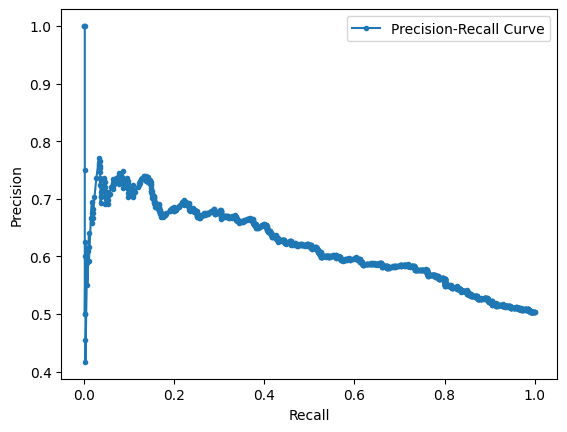

Validation loss: 0.686925
Accuracy: 0.5212
F1 Score: 0.4141
Precision: 0.5675
Recall: 0.5212
AUROC: 0.6282

Epoch 2/10
Training loss: 0.136882


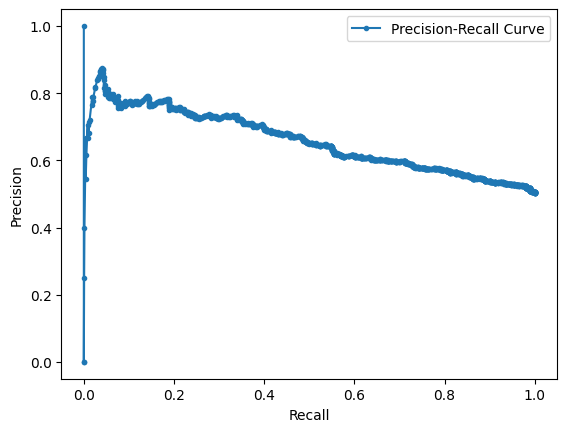

Validation loss: 0.665453
Accuracy: 0.5976
F1 Score: 0.5879
Precision: 0.6065
Recall: 0.5976
AUROC: 0.6623

Epoch 3/10
Training loss: 0.124501


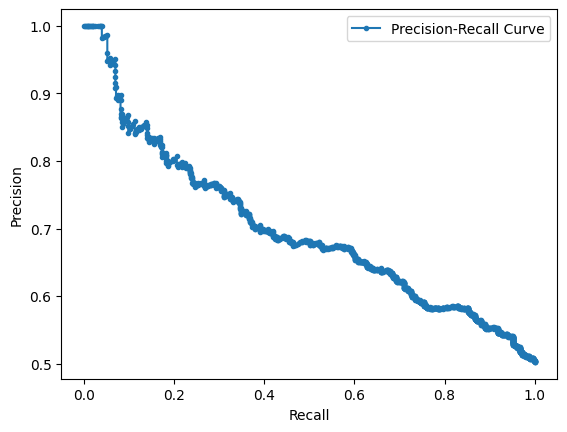

Validation loss: 0.647984
Accuracy: 0.6062
F1 Score: 0.5949
Precision: 0.6183
Recall: 0.6062
AUROC: 0.6898

Epoch 4/10
Training loss: 0.106414


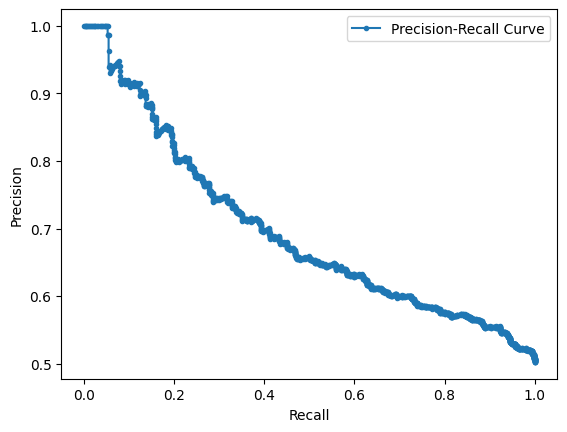

Validation loss: 0.638435
Accuracy: 0.6255
F1 Score: 0.6248
Precision: 0.6268
Recall: 0.6255
AUROC: 0.6795

Epoch 5/10
Training loss: 0.080530


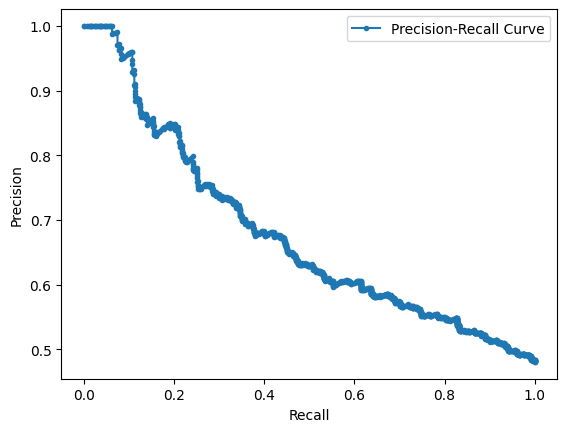

Validation loss: 0.660520
Accuracy: 0.6220
F1 Score: 0.6035
Precision: 0.6378
Recall: 0.6220
AUROC: 0.6678

Epoch 6/10
Training loss: 0.062167


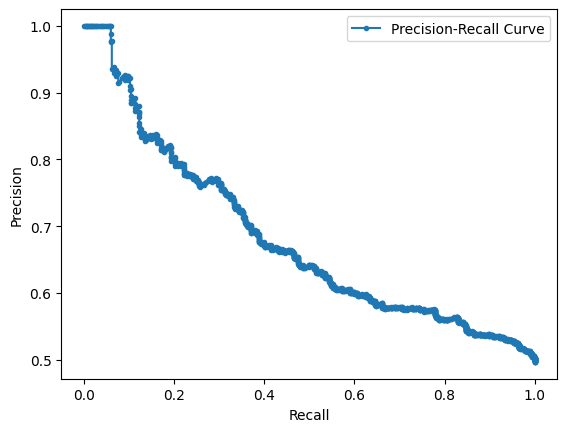

Validation loss: 0.670898
Accuracy: 0.6094
F1 Score: 0.6034
Precision: 0.6155
Recall: 0.6094
AUROC: 0.6638

Epoch 7/10
Training loss: 0.044819


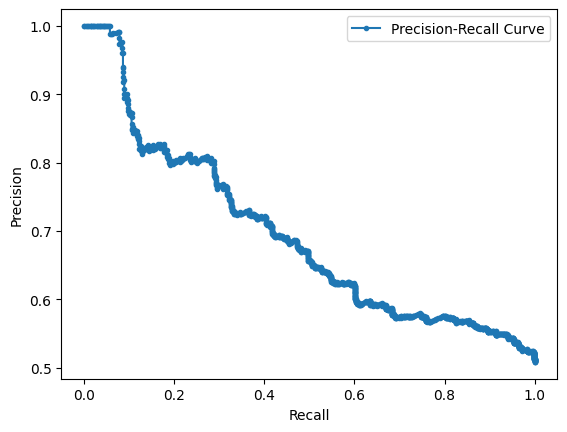

Validation loss: 0.692698
Accuracy: 0.6055
F1 Score: 0.6043
Precision: 0.6080
Recall: 0.6055
AUROC: 0.6660
Early stopping triggered


In [12]:
# 학습 루프
epochs = 10
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss = train_with_focal_loss(model, train_dataloader, optimizer, scheduler, FocalLoss())
    print(f"Training loss: {train_loss:.6f}")

    val_loss, accuracy, f1, precision, recall, auroc = evaluate(model, val_dataloader)
    print(f"Validation loss: {val_loss:.6f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUROC: {auroc:.4f}")

    # Early stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        break

In [ ]:
# Final evaluation on test set
test_loss, test_accuracy, test_f1, test_precision, test_recall, test_auroc = evaluate(model, test_dataloader)
print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.6f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUROC: {test_auroc:.4f}")

# Model (Balanced Label)

In this part, I have used balanced class (0:1 proportion is balanced to 50:50) to perform prediction.

In [ ]:
import torch
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, roc_curve, precision_recall_curve, auc)
import matplotlib.pyplot as plt
import numpy as np

# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ClinicalBERT Loading
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = BertForSequenceClassification.from_pretrained(
    'emilyalsentzer/Bio_ClinicalBERT',
    num_labels=2,
    hidden_dropout_prob=0.2  # Adjusted dropout rate
).to(device)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

In [ ]:
# Data Preparation and Tokenization
def prepare_data_and_tokenize(df):
    texts = df['text'].tolist()
    labels = df['Label'].tolist()

    input_ids = []
    attention_masks = []

    print("Tokenizing data...")
    for text in tqdm(texts, desc="Tokenizing texts", unit="text"):
        encoded_dict = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [ ]:
# DataLoader Creation
def create_data_loader(input_ids, attention_masks, labels, batch_size=16):
    dataset = TensorDataset(input_ids, attention_masks, labels)
    sampler = RandomSampler(dataset)  # Using a random sampler
    return DataLoader(dataset, sampler=sampler, batch_size=batch_size)

In [ ]:
# Training Function
def train_model(model, dataloader, optimizer, scheduler, loss_fn):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        scheduler.step()

    return total_loss / len(dataloader)

In [ ]:
# Evaluation Function
def evaluate(model, dataloader):
    model.eval()
    total_eval_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            total_eval_loss += outputs.loss.item()

            logits = outputs.logits
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())
            probs = torch.nn.functional.softmax(logits, dim=1)
            all_probs.extend(probs.cpu().numpy()[:, 1])

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    auroc = roc_auc_score(all_labels, all_probs)

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(recall_vals, precision_vals, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    return total_eval_loss / len(dataloader), accuracy, f1, precision, recall, auroc


In [ ]:
# Preparing Datasets
# train_input_ids, train_attention_masks, train_labels = prepare_data_and_tokenize(train_upsampled)
# val_input_ids, val_attention_masks, val_labels = prepare_data_and_tokenize(val_upsampled)
# test_input_ids, test_attention_masks, test_labels = prepare_data_and_tokenize(test_upsampled)
from google.colab import drive
drive.mount('/content/drive')
import os
drive_path ='/content/drive/MyDrive/STAT3612_dataset/STAT3612_data_preprocessing_final/upsampling_test'
os.makedirs(drive_path,exist_ok=True)

train_input_ids, train_attention_masks, train_labels = torch.load(os.path.join(drive_path, 'train_upsampled.pt'))
val_input_ids, val_attention_masks, val_labels = torch.load(os.path.join(drive_path, 'val_upsampled.pt'))
test_input_ids, test_attention_masks, test_labels = torch.load(os.path.join(drive_path, 'test_upsampled.pt'))


# Creating DataLoaders
train_dataloader = create_data_loader(train_input_ids, train_attention_masks, train_labels, batch_size=16)
val_dataloader = create_data_loader(val_input_ids, val_attention_masks, val_labels, batch_size=16)
test_dataloader = create_data_loader(test_input_ids, test_attention_masks, test_labels, batch_size=16)


Mounted at /content/drive


<ipython-input-7-d90b4eb266ff>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_input_ids, train_attention_masks, train_labels = torch.load(os.path.join(drive_path, '

In [ ]:
# import os
# drive_path ='/content/drive/MyDrive/STAT3612_dataset/STAT3612_data_preprocessing_final/upsampling_test'
# os.makedirs(drive_path,exist_ok=True)
# torch.save((train_input_ids, train_attention_masks, train_labels), os.path.join(drive_path, 'train_upsampled.pt'))
# torch.save((val_input_ids, val_attention_masks, val_labels), os.path.join(drive_path, 'val_upsampled.pt'))
# torch.save((test_input_ids, test_attention_masks, test_labels), os.path.join(drive_path, 'test_upsampled.pt'))

In [ ]:
# Optimizer setup
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,  # Learning rate
    eps=1e-8, # Epsilon value to avoid division by zero
    weight_decay = 1e-4  # Weight decay (L2 regularization)
)

# Scheduler setup
num_epochs = 10  # Number of epochs
total_steps = len(train_dataloader) * num_epochs  # Total training steps
num_warmup_steps = int(0.1 * total_steps)  # 10% of total steps as warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)

# Early stopping setup
early_stopping = EarlyStopping(
    patience=3,  # Number of epochs to wait for improvement
    verbose=True  # Print messages when early stopping is triggered
)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/10
Training loss: 0.686448


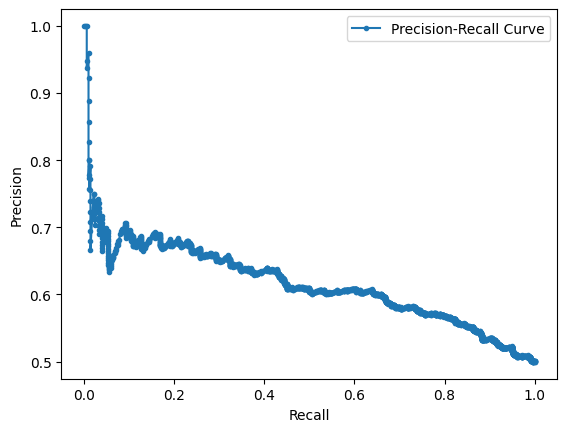

Validation loss: 0.671180
Accuracy: 0.5969
F1 Score: 0.5831
Precision: 0.6116
Recall: 0.5969
AUROC: 0.6367

Epoch 2/10
Training loss: 0.609930


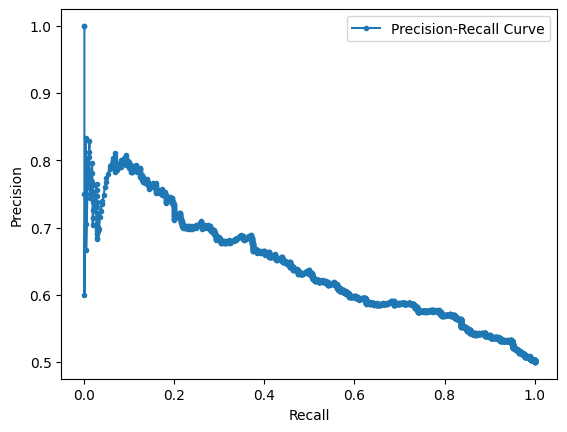

Validation loss: 0.667999
Accuracy: 0.5984
F1 Score: 0.5965
Precision: 0.6003
Recall: 0.5984
AUROC: 0.6511

Epoch 3/10
Training loss: 0.455311


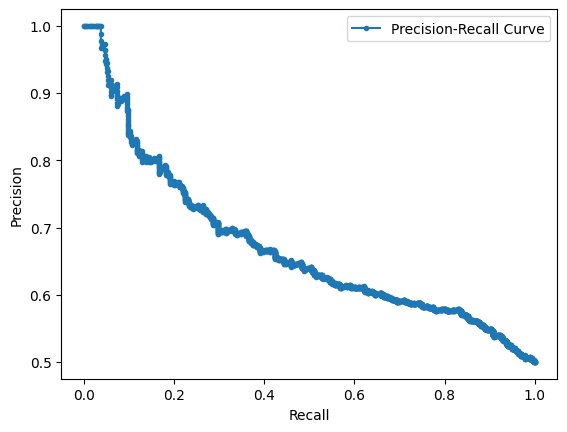

Validation loss: 0.859419
Accuracy: 0.5908
F1 Score: 0.5542
Precision: 0.6352
Recall: 0.5908
AUROC: 0.6634

Epoch 4/10
Training loss: 0.268702


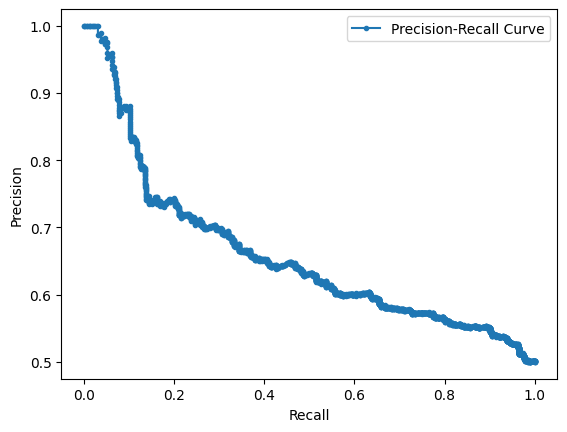

Validation loss: 0.917849
Accuracy: 0.6055
F1 Score: 0.6052
Precision: 0.6059
Recall: 0.6055
AUROC: 0.6502

Epoch 5/10
Training loss: 0.164545


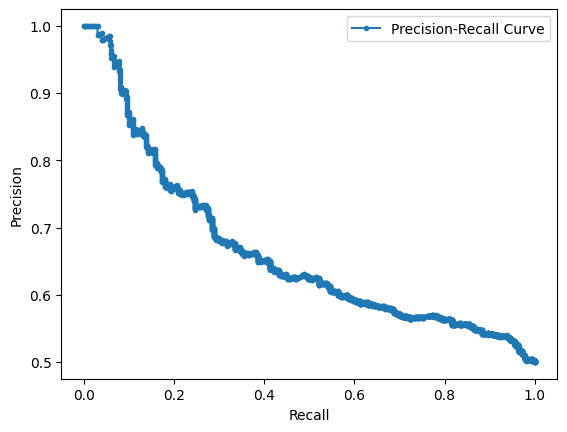

Validation loss: 1.121499
Accuracy: 0.5930
F1 Score: 0.5921
Precision: 0.5938
Recall: 0.5930
AUROC: 0.6485
Early stopping triggered


In [ ]:
# Training Loop
epochs = 10
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss = train_model(model, train_dataloader, optimizer, scheduler, torch.nn.CrossEntropyLoss())
    print(f"Training loss: {train_loss:.6f}")

    val_loss, accuracy, f1, precision, recall, auroc = evaluate(model, val_dataloader)
    print(f"Validation loss: {val_loss:.6f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUROC: {auroc:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        break

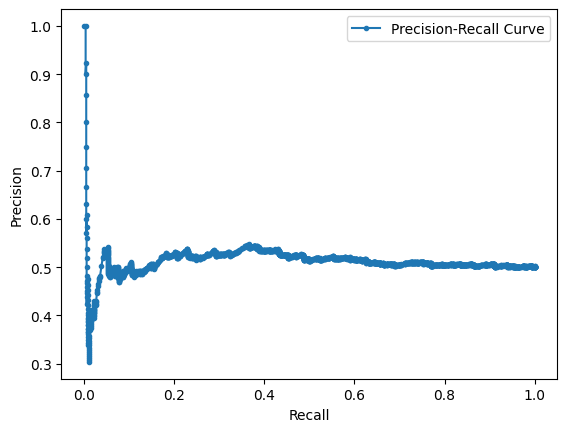


Test Results:
Test Loss: 1.463228
Test Accuracy: 0.5165
Test F1 Score: 0.5164
Test Precision: 0.5165
Test Recall: 0.5165
Test AUROC: 0.5225


In [ ]:
# Final Evaluation on Test Set
test_loss, test_accuracy, test_f1, test_precision, test_recall, test_auroc = evaluate(model, test_dataloader)
print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.6f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUROC: {test_auroc:.4f}")

#Different scheduler

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, WeightedRandomSampler
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, precision_recall_curve)
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ClinicalBERT 불러오기
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = BertForSequenceClassification.from_pretrained(
    'emilyalsentzer/Bio_ClinicalBERT',
    num_labels=2,
    hidden_dropout_prob=0.2  # Dropout 설정
).to(device)

In [14]:
# Focal Loss 정의
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.815, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = torch.nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Early Stopping 정의
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

In [15]:
# 데이터 준비 및 토큰화 함수
def prepare_data_and_tokenize(df):
    texts = df['text'].tolist()
    labels = df['Label'].tolist()

    input_ids = []
    attention_masks = []

    print("Tokenizing data...")
    for text in tqdm(texts, desc="Tokenizing texts", unit="text"):
        encoded_dict = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [16]:
# DataLoader 생성 함수 (Weighted Sampler 추가)
def create_data_loader(input_ids, attention_masks, labels, batch_size=32, sampler_type="weighted"):
    dataset = TensorDataset(input_ids, attention_masks, labels)
    if sampler_type == "weighted":
        class_counts = np.bincount(labels.numpy())
        class_weights = 1.0 / class_counts
        weights = class_weights[labels.numpy()]
        sampler = WeightedRandomSampler(weights, len(weights))
    else:
        sampler = RandomSampler(dataset)
    return DataLoader(dataset, sampler=sampler, batch_size=batch_size)

# Training function with Focal Loss
def train_with_focal_loss(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()
        loss.backward()

        optimizer.step()

    return total_loss / len(dataloader)

In [17]:
# 평가 함수
def evaluate(model, dataloader):
    model.eval()
    total_eval_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            total_eval_loss += outputs.loss.item()

            logits = outputs.logits
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())
            probs = torch.nn.functional.softmax(logits, dim=1)
            all_probs.extend(probs.cpu().numpy()[:, 1])

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    auroc = roc_auc_score(all_labels, all_probs)

    return total_eval_loss / len(dataloader), accuracy, f1, precision, recall, auroc


In [22]:
from google.colab import drive
drive.mount('/content/drive')
import os
drive_path ='/content/drive/MyDrive/STAT3612_dataset/STAT3612_data_preprocessing_final/imbalnce_test'
os.makedirs(drive_path,exist_ok=True)

train_input_ids, train_attention_masks, train_labels = torch.load(os.path.join(drive_path, 'train.pt'))
val_input_ids, val_attention_masks, val_labels = torch.load(os.path.join(drive_path, 'val.pt'))
test_input_ids, test_attention_masks, test_labels = torch.load(os.path.join(drive_path, 'test.pt'))

train_dataloader = create_data_loader(train_input_ids, train_attention_masks, train_labels, sampler_type="weighted")
val_dataloader = create_data_loader(val_input_ids, val_attention_masks, val_labels)
test_dataloader = create_data_loader(test_input_ids, test_attention_masks, test_labels)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-22-34b25161a32b>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_input_ids, train_attention_masks, train_labels = torch.load(os.path.join(drive_path, '

In [23]:
# Optimizer 및 LR Scheduler 설정
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

# Early Stopping 초기화
early_stopping = EarlyStopping(patience=3, verbose=True)

# Loss Function 설정
loss_fn = FocalLoss(alpha=0.815, gamma=2)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
# 학습 루프
epochs = 10
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss = train_with_focal_loss(model, train_dataloader, optimizer, loss_fn)
    print(f"Training loss: {train_loss:.6f}")

    val_loss, accuracy, f1, precision, recall, auroc = evaluate(model, val_dataloader)
    print(f"Validation loss: {val_loss:.6f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUROC: {auroc:.4f}")

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Stopping early.")
        break



Epoch 1/10
Training loss: 0.143763
Validation loss: 0.675945
Accuracy: 0.5825
F1 Score: 0.5730
Precision: 0.5911
Recall: 0.5825
AUROC: 0.6374

Epoch 2/10
Training loss: 0.128535
Validation loss: 0.653283
Accuracy: 0.6187
F1 Score: 0.6184
Precision: 0.6190
Recall: 0.6187
AUROC: 0.6719

Epoch 3/10
Training loss: 0.115384
Validation loss: 0.649401
Accuracy: 0.6295
F1 Score: 0.6187
Precision: 0.6454
Recall: 0.6295
AUROC: 0.6807

Epoch 4/10
Training loss: 0.088299
Validation loss: 0.754071
Accuracy: 0.5814
F1 Score: 0.5350
Precision: 0.6356
Recall: 0.5814
AUROC: 0.6488

Epoch 5/10
Training loss: 0.059496
Validation loss: 0.886478
Accuracy: 0.5732
F1 Score: 0.5289
Precision: 0.6185
Recall: 0.5732
AUROC: 0.6423

Epoch 6/10
Training loss: 0.043990
Validation loss: 0.853781
Accuracy: 0.5742
F1 Score: 0.5468
Precision: 0.6036
Recall: 0.5742
AUROC: 0.6453
Early stopping triggered
Stopping early.


In [25]:
# Final evaluation on test set
test_loss, test_accuracy, test_f1, test_precision, test_recall, test_auroc = evaluate(model, test_dataloader)
print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.6f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUROC: {test_auroc:.4f}")


Test Results:
Test Loss: 1.132653
Test Accuracy: 0.4881
Test F1 Score: 0.4292
Test Precision: 0.4855
Test Recall: 0.4881
Test AUROC: 0.4964
